고혈압 여부 갯수:
고혈압여부
0    288019
1     57492
Name: count, dtype: int64
XGBoost Best F1 Score: 0.62
XGBoost Weighted F1 Score: 0.82
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     57604
           1       0.45      1.00      0.62     11499

    accuracy                           0.79     69103
   macro avg       0.72      0.88      0.74     69103
weighted avg       0.91      0.79      0.82     69103



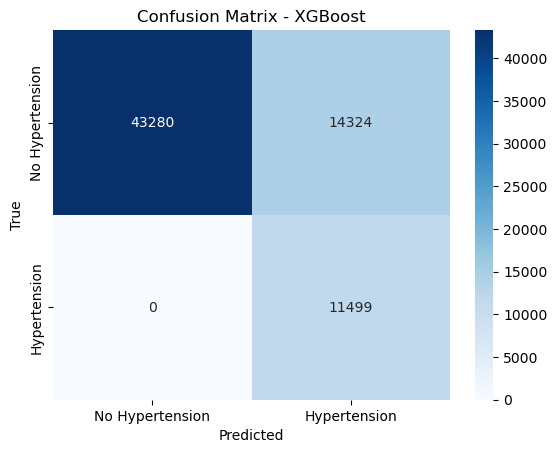

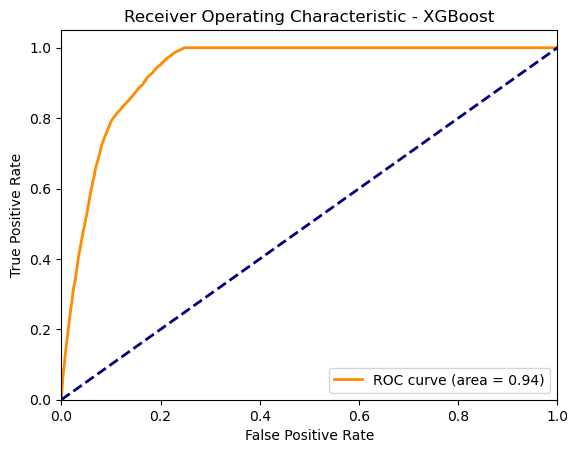

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# 데이터 로드 및 전처리
data = pd.read_csv('/Users/yeomsihun/Desktop/의료인공지능/sw응용/국민건강보험공단_건강검진정보_20221231.CSV', encoding='euc-kr')

data['고혈압여부'] = ((data['수축기혈압'] >= 140) | (data['이완기혈압'] >= 90)).astype(int)

data.drop(['혈청지오티(AST)', '혈청크레아티닌', '감마지티피', '혈색소', '요단백', '기준년도', '가입자일련번호', '시도코드', '구강검진수검여부', '총콜레스테롤', 'LDL콜레스테롤', '치아우식증유무', '치석', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '트리글리세라이드'], axis=1, inplace=True)

data = data.dropna()

# 고혈압 여부의 각 클래스 갯수 출력
hypertension_counts = data['고혈압여부'].value_counts()
print("고혈압 여부 갯수:")
print(hypertension_counts)

# 데이터 분할 및 스케일링 (분할 먼저 수행)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['고혈압여부'])
X_train = train_data.drop(columns=['고혈압여부'])
y_train = train_data['고혈압여부']

X_test = test_data.drop(columns=['고혈압여부'])
y_test = test_data['고혈압여부']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 언더샘플링을 통해 클래스 불균형 해결 (학습 데이터에서만)
class_0 = train_data[train_data['고혈압여부'] == 0]
class_1 = train_data[train_data['고혈압여부'] == 1]

# 클래스 0을 클래스 1의 갯수와 동일하게 랜덤하게 샘플링
class_0_under = class_0.sample(len(class_1), random_state=42)
train_data_under = pd.concat([class_0_under, class_1], axis=0)

X_train_under = train_data_under.drop(columns=['고혈압여부'])
y_train_under = train_data_under['고혈압여부']

X_train_under = scaler.fit_transform(X_train_under)

# 최적 하이퍼파라미터를 사용하여 XGBoost 모델 설정
best_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.001,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.7
}

best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    **best_params
)

# 모델 학습
best_xgb_model.fit(X_train_under, y_train_under)

# 최적의 모델로 예측
y_pred = best_xgb_model.predict(X_test)
y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# 성능 평가 및 결과 출력
f1_xgb = f1_score(y_test, y_pred)
report_xgb = classification_report(y_test, y_pred, output_dict=True)
weighted_f1_xgb = report_xgb['weighted avg']['f1-score']
print(f"XGBoost Best F1 Score: {f1_xgb:.2f}")
print(f"XGBoost Weighted F1 Score: {weighted_f1_xgb:.2f}")
print("Best Hyperparameters:", best_params)
print(classification_report(y_test, y_pred))

# 혼동 행렬 그리기
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Hypertension', 'Hypertension'], yticklabels=['No Hypertension', 'Hypertension'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

plot_confusion_matrix(y_test, y_pred, title='XGBoost')

# ROC 곡선 그리기
def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, y_pred_prob, title='XGBoost')
